In [65]:
from kiteconnect import KiteConnect
import os
from pprint import pprint
from dotenv import load_dotenv
from dataclasses import dataclass
import numpy as np
import pandas as pd
import talib

load_dotenv()

True

In [26]:
api_key = os.getenv("KITE_API_KEY")
kite = KiteConnect(api_key=api_key)

access_token = os.getenv("KITE_ACCESS_TOKEN")
if not access_token:
    raise ValueError("Access token not found in .env file. Please run the server and login first.")

kite.set_access_token(access_token)
print("Successfully authenticated with Zerodha!")

Successfully authenticated with Zerodha!


In [27]:
# Get all NSE instruments
instruments = pd.DataFrame(kite.instruments("NSE"))

# Filter for only EQ instruments
eq_instruments = instruments[instruments['segment'] == 'NSE']

top_50_companies = [
    "Reliance Industries Ltd", "JSW Steel Ltd",
    "HDFC Bank Ltd", "Tata Steel Ltd",
    "Tata Consultancy Services Ltd", "Adani Enterprises Ltd",
    "Bharti Airtel Ltd", "Wipro Ltd",
    "ICICI Bank Ltd", "Grasim Industries Ltd",
    "State Bank of India", "Divi's Laboratories Ltd",
    "Infosys Ltd", "SBI Life Insurance Company Ltd",
    "Bajaj Finance Ltd", "Britannia Industries Ltd",
    "Hindustan Unilever Ltd", "Cipla Ltd",
    "ITC Ltd", "Dr. Reddy's Laboratories Ltd",
    "Larsen & Toubro Ltd", "Eicher Motors Ltd",
    "HCL Technologies Ltd", "Hero MotoCorp Ltd",
    "Kotak Mahindra Bank Ltd", "HDFC Life Insurance Company Ltd",
    "Sun Pharmaceutical Industries Ltd", "BPCL",
    "Maruti Suzuki Ltd", "Coal India Ltd",
    "Axis Bank Ltd", "Bajaj Auto Ltd",
    "Mahindra & Mahindra Ltd", "Apollo Hospitals Enterprise Ltd",
    "UltraTech Cement Ltd", "IndusInd Bank Ltd",
    "NTPC Ltd", "Hindalco Industries Ltd",
    "Bajaj Finserv Ltd", "Tata Consumer Products Ltd",
    "Asian Paints Ltd", "Adani Ports and Special Economic Zone Ltd",
    "Power Grid Corporation of India Ltd", "UPL Ltd",
    "Tata Motors Ltd", "ONGC",
    "Nestle India Ltd", "Shree Cement Ltd",
    "Titan Company Ltd", "SBI Cards and Payment Services Ltd"
]

# Dictionary of known trading symbols for companies
trading_symbols = {
    "Tata Consultancy Services": "TCS",
    "Divi's Laboratories": "DIVISLAB",
    "SBI Life Insurance Company": "SBILIFE",
    "Dr. Reddy's Laboratories": "DRREDDY",
    "HDFC Life Insurance Company": "HDFCLIFE",
    "Sun Pharmaceutical Industries": "SUNPHARMA",
    "Apollo Hospitals Enterprise": "APOLLOHOSP",
    "Hindalco Industries": "HINDALCO",
    "Tata Consumer Products": "TATACONSUM",
    "Adani Ports and Special Economic Zone": "ADANIPORTS",
    "Power Grid Corporation of India": "POWERGRID",
    "SBI Cards and Payment Services": "SBICARD"
}

# Function to find the best match for a company name
def find_instrument_token(company_name):
    # Clean the company name
    clean_name = company_name.replace(' Ltd', '').replace(' Limited', '').strip()
    
    # Try known trading symbols first
    for key, symbol in trading_symbols.items():
        if key in clean_name:
            exact_symbol_match = eq_instruments[eq_instruments['tradingsymbol'] == symbol]
            if not exact_symbol_match.empty:
                return exact_symbol_match.iloc[0]
    
    # Try exact match with trading symbol
    exact_match = eq_instruments[eq_instruments['tradingsymbol'].str.contains('^' + clean_name + '$', case=False, regex=True)]
    if not exact_match.empty:
        return exact_match.iloc[0]
    
    # Try partial match with name
    partial_match = eq_instruments[eq_instruments['name'].str.contains(clean_name, case=False, regex=False)]
    if not partial_match.empty:
        return partial_match.iloc[0]
    
    # Try matching with trading symbol (without spaces)
    symbol_match = eq_instruments[eq_instruments['tradingsymbol'].str.contains(clean_name.replace(' ', ''), case=False, regex=False)]
    if not symbol_match.empty:
        return symbol_match.iloc[0]
    
    return None

companies = []

# Find instrument tokens for each company
for company in top_50_companies:
    match = find_instrument_token(company)
    if match is not None:
        companies.append({
            'Company Name': company,
            'Trading Symbol': match['tradingsymbol'],
            'Instrument Token': match['instrument_token'],
            'Exchange Token': match['exchange_token'],
            'Name in Exchange': match['name']
        })
    else:
        print(f"Could not find match for: {company}")
        
companies


[{'Company Name': 'Reliance Industries Ltd',
  'Trading Symbol': 'RELIANCE',
  'Instrument Token': np.int64(738561),
  'Exchange Token': '2885',
  'Name in Exchange': 'RELIANCE INDUSTRIES'},
 {'Company Name': 'JSW Steel Ltd',
  'Trading Symbol': 'JSWSTEEL',
  'Instrument Token': np.int64(3001089),
  'Exchange Token': '11723',
  'Name in Exchange': 'JSW STEEL'},
 {'Company Name': 'HDFC Bank Ltd',
  'Trading Symbol': 'HDFCBANK',
  'Instrument Token': np.int64(341249),
  'Exchange Token': '1333',
  'Name in Exchange': 'HDFC BANK'},
 {'Company Name': 'Tata Steel Ltd',
  'Trading Symbol': 'TATASTEEL',
  'Instrument Token': np.int64(895745),
  'Exchange Token': '3499',
  'Name in Exchange': 'TATA STEEL'},
 {'Company Name': 'Tata Consultancy Services Ltd',
  'Trading Symbol': 'TCS',
  'Instrument Token': np.int64(2953217),
  'Exchange Token': '11536',
  'Name in Exchange': 'TATA CONSULTANCY SERV LT'},
 {'Company Name': 'Adani Enterprises Ltd',
  'Trading Symbol': 'ADANIENT',
  'Instrument Tok

In [91]:
historical_dfs = {}

for company in companies:
    start_date = pd.Timestamp('2015-01-01')
    end_date = pd.Timestamp('2025-10-04')
    chunk_size = pd.Timedelta(days=2000)
    
    all_data = []
    current_date = start_date
    
    while current_date < end_date:
        chunk_end = min(current_date + chunk_size, end_date)
        
        data = kite.historical_data(company['Instrument Token'],
                                  from_date=current_date,
                                  to_date=chunk_end,
                                  interval="day")
        all_data.extend(data)
        
        current_date = chunk_end + pd.Timedelta(days=1)
    
    df = pd.DataFrame(all_data)
    historical_dfs[company['Trading Symbol']] = df

In [92]:
# NOTE: date is the opening time of the candle
historical_dfs['HDFCBANK']

,date,open,high,low,close,volume
0,2015-01-01 00:00:00+05:30,237.80,238.60,236.2,238.00,1772470
1,2015-01-02 00:00:00+05:30,237.60,242.30,237.6,241.30,2950192
2,2015-01-05 00:00:00+05:30,242.50,242.60,238.8,239.30,2398000
3,2015-01-06 00:00:00+05:30,238.50,239.10,234.4,235.60,4109840
4,2015-01-07 00:00:00+05:30,234.90,237.80,234.0,236.20,2873056
...,...,...,...,...,...,...
2657,2025-09-26 00:00:00+05:30,945.10,951.45,941.3,945.05,14874656
2658,2025-09-29 00:00:00+05:30,946.05,956.80,939.1,950.30,32398179
2659,2025-09-30 00:00:00+05:30,958.05,960.00,946.3,951.00,28296687
2660,2025-10-01 00:00:00+05:30,952.70,969.60,946.0,965.25,25350832


In [93]:
def add_indicators(df):
    # 1. 200-day moving average
    df['MA200'] = talib.SMA(df['close'], timeperiod=200)
        
    # 2. Bollinger Bands (20-day MA with 2.5 std dev)
    df['BB_middle'], df['BB_upper'], df['BB_lower'] = talib.BBANDS(
        df['close'], 
        timeperiod=20,
        nbdevup=2.5,
        nbdevdn=2.5
    )
    
    # 3. 2-day RSI
    df['RSI2'] = talib.RSI(df['close'], timeperiod=2)
    
    # 4. 150-day price change percentage (or from start if less than 150 days)
    df['Price_Change_150'] = ((df['close'] - df['close'].iloc[0]) / df['close'].iloc[0] * 100).where(
        df.index < 150, 
        df['close'].pct_change(periods=150) * 100
    )
    
    return df

for key, df in historical_dfs.items():
    historical_dfs[key] = add_indicators(df)
    
historical_dfs['HDFCBANK']

,date,open,high,low,close,volume,MA200,BB_middle,BB_upper,BB_lower,RSI2,Price_Change_150
0,2015-01-01 00:00:00+05:30,237.80,238.60,236.2,238.00,1772470,NaN,NaN,NaN,NaN,NaN,0.000000
1,2015-01-02 00:00:00+05:30,237.60,242.30,237.6,241.30,2950192,NaN,NaN,NaN,NaN,NaN,1.386555
2,2015-01-05 00:00:00+05:30,242.50,242.60,238.8,239.30,2398000,NaN,NaN,NaN,NaN,62.264151,0.546218
3,2015-01-06 00:00:00+05:30,238.50,239.10,234.4,235.60,4109840,NaN,NaN,NaN,NaN,25.984252,-1.008403
4,2015-01-07 00:00:00+05:30,234.90,237.80,234.0,236.20,2873056,NaN,NaN,NaN,NaN,37.748344,-0.756303
...,...,...,...,...,...,...,...,...,...,...,...,...
2657,2025-09-26 00:00:00+05:30,945.10,951.45,941.3,945.05,14874656,930.15650,982.343918,960.895,939.446082,1.938160,10.055898
2658,2025-09-29 00:00:00+05:30,946.05,956.80,939.1,950.30,32398179,930.23800,982.374491,960.880,939.385509,56.237679,10.307603
2659,2025-09-30 00:00:00+05:30,958.05,960.00,946.3,951.00,28296687,930.33500,981.404315,961.205,941.005685,61.868238,10.120426
2660,2025-10-01 00:00:00+05:30,952.70,969.60,946.0,965.25,25350832,930.51325,981.670953,961.745,941.819047,93.887566,14.420341


In [94]:
def generate_signals(df):
    # 0: No signal, 1: Buy signal
    df['Signal'] = 0  
    
    # Rule 1: Stock above 200-day MA
    uptrend = df['close'] > df['MA200']
    
    # Rule 2: Stock closes below lower Bollinger Band
    pullback = df['close'] < df['BB_lower']
    
    # Generate buy signals where both conditions are met
    df.loc[uptrend & pullback, 'Signal'] = 1
    
    df.index = pd.to_datetime(df.date)
    
    return df

for key, df in historical_dfs.items():
    historical_dfs[key] = generate_signals(df)

historical_dfs['HDFCBANK']

,date,open,high,low,close,volume,MA200,BB_middle,BB_upper,BB_lower,RSI2,Price_Change_150,Signal
date,,,,,,,,,,,,,
2015-01-01 00:00:00+05:30,2015-01-01 00:00:00+05:30,237.80,238.60,236.2,238.00,1772470,NaN,NaN,NaN,NaN,NaN,0.000000,0
2015-01-02 00:00:00+05:30,2015-01-02 00:00:00+05:30,237.60,242.30,237.6,241.30,2950192,NaN,NaN,NaN,NaN,NaN,1.386555,0
2015-01-05 00:00:00+05:30,2015-01-05 00:00:00+05:30,242.50,242.60,238.8,239.30,2398000,NaN,NaN,NaN,NaN,62.264151,0.546218,0
2015-01-06 00:00:00+05:30,2015-01-06 00:00:00+05:30,238.50,239.10,234.4,235.60,4109840,NaN,NaN,NaN,NaN,25.984252,-1.008403,0
2015-01-07 00:00:00+05:30,2015-01-07 00:00:00+05:30,234.90,237.80,234.0,236.20,2873056,NaN,NaN,NaN,NaN,37.748344,-0.756303,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-26 00:00:00+05:30,2025-09-26 00:00:00+05:30,945.10,951.45,941.3,945.05,14874656,930.15650,982.343918,960.895,939.446082,1.938160,10.055898,0
2025-09-29 00:00:00+05:30,2025-09-29 00:00:00+05:30,946.05,956.80,939.1,950.30,32398179,930.23800,982.374491,960.880,939.385509,56.237679,10.307603,0
2025-09-30 00:00:00+05:30,2025-09-30 00:00:00+05:30,958.05,960.00,946.3,951.00,28296687,930.33500,981.404315,961.205,941.005685,61.868238,10.120426,0


In [95]:
# Display the last few signals
hdfcbank_df = historical_dfs['HDFCBANK']
signal_days = hdfcbank_df[hdfcbank_df['Signal'] == 1].tail()
print("\nBuy Signal Days for HDFCBANK:")
print(signal_days[['date', 'close', 'MA200', 'BB_lower', 'RSI2', 'Price_Change_150']])


Buy Signal Days for HDFCBANK:
                                               date  close     MA200  \
date                                                                   
2019-07-23 00:00:00+05:30 2019-07-23 00:00:00+05:30  565.9  548.5540   
2021-04-12 00:00:00+05:30 2021-04-12 00:00:00+05:30  683.5  650.0465   
2021-07-20 00:00:00+05:30 2021-07-20 00:00:00+05:30  721.6  716.1610   
2025-08-28 00:00:00+05:30 2025-08-28 00:00:00+05:30  957.8  922.6830   
2025-08-29 00:00:00+05:30 2025-08-29 00:00:00+05:30  951.6  923.0745   

                             BB_lower      RSI2  Price_Change_150  
date                                                               
2019-07-23 00:00:00+05:30  566.124933  2.727312          7.728917  
2021-04-12 00:00:00+05:30  684.994350  1.751358         20.887867  
2021-07-20 00:00:00+05:30  723.278465  6.266065          4.142012  
2025-08-28 00:00:00+05:30  961.723450  0.817140         16.012597  
2025-08-29 00:00:00+05:30  953.813695  0.522387         

In [96]:
MAX_TRADES = 5
BUY_LIMIT_PCT = 0.03
MAX_HOLD_DAYS = 10
INITIAL_CAPITAL = 100000.0

@dataclass
class PendingOrder:
    symbol: str
    limit_price: float
    quantity: int
    reserved_amount: float
    order_date: pd.Timestamp


@dataclass
class OpenTrade:
    symbol: str
    quantity: int
    entry_price: float
    entry_date: pd.Timestamp


@dataclass
class ExitOrder:
    symbol: str
    trade: OpenTrade
    trigger_date: pd.Timestamp


@dataclass
class ClosedTrade:
    symbol: str
    quantity: int
    entry_price: float
    exit_price: float
    entry_date: pd.Timestamp
    exit_date: pd.Timestamp

    def pnl(self) -> float:
        return (self.exit_price - self.entry_price) * self.quantity

    def pnl_pct(self) -> float:
        return (self.exit_price / self.entry_price - 1) * 100


pending_orders: dict[str, PendingOrder] = {}
open_trades: dict[str, OpenTrade] = {}
exit_orders: dict[str, ExitOrder] = {}
closed_trades: list[ClosedTrade] = []
capital = INITIAL_CAPITAL

all_dates = pd.DatetimeIndex(sorted(set().union(*[df.index for df in historical_dfs.values()])))


# --- MAIN SIMULATION LOOP ---
for date in all_dates:
    # === 1. EXECUTE PENDING ORDERS (ENTRY FILLS OR CANCELS) ===
    for sym, order in list(pending_orders.items()):
        df = historical_dfs[sym]
        if date not in df.index:
            capital += order.reserved_amount
            del pending_orders[sym]
            continue

        row = df.loc[date]
        filled = False

        if row['open'] <= order.limit_price:
            fill_price = float(row['open'])
            qty = int(order.reserved_amount // fill_price)
            if qty > 0:
                spent = qty * fill_price
                leftover = order.reserved_amount - spent
                capital += leftover
                open_trades[sym] = OpenTrade(
                    symbol=sym, quantity=qty, entry_price=fill_price, entry_date=date
                )
            else:
                capital += order.reserved_amount
            filled = True

        elif row['low'] <= order.limit_price:
            fill_price = float(order.limit_price)
            qty = order.quantity
            spent = qty * fill_price
            leftover = order.reserved_amount - spent
            capital += leftover
            open_trades[sym] = OpenTrade(
                symbol=sym, quantity=qty, entry_price=fill_price, entry_date=date
            )
            filled = True

        if not filled:
            # no fill; refund
            capital += order.reserved_amount

        del pending_orders[sym]

    # === 2. EXECUTE EXIT ORDERS (CLOSE POSITIONS) ===
    for sym, ex in list(exit_orders.items()):
        df = historical_dfs[sym]
        if date not in df.index:
            continue
        close_price = float(df.at[date, 'open'])
        trade = ex.trade
        closed = ClosedTrade(
            symbol=sym,
            quantity=trade.quantity,
            entry_price=trade.entry_price,
            exit_price=close_price,
            entry_date=trade.entry_date,
            exit_date=date,
        )
        capital += trade.quantity * close_price
        closed_trades.append(closed)
        del exit_orders[sym]

    # === 3. CHECK EXIT CONDITIONS FOR OPEN TRADES ===
    for sym, trade in list(open_trades.items()):
        df = historical_dfs[sym]
        if date not in df.index:
            continue

        idx = df.index.get_loc(date)
        if idx == 0:
            continue
        rsi_prev = df.iat[idx - 1, df.columns.get_loc('RSI2')]
        rsi_now = df.iat[idx, df.columns.get_loc('RSI2')]
        rsi_cross = (rsi_prev <= 50) and (rsi_now > 50)

        entry_idx = df.index.get_loc(trade.entry_date)
        held_days = idx - entry_idx

        if rsi_cross or held_days >= MAX_HOLD_DAYS:
            # schedule exit next day if possible
            if idx + 1 < len(df.index):
                exit_orders[sym] = ExitOrder(
                    symbol=sym, trade=trade, trigger_date=date
                )
            else:
                # last available day; close now at close
                close_price = float(df.at[date, 'close'])
                closed = ClosedTrade(
                    symbol=sym,
                    quantity=trade.quantity,
                    entry_price=trade.entry_price,
                    exit_price=close_price,
                    entry_date=trade.entry_date,
                    exit_date=date,
                )
                capital += trade.quantity * close_price
                closed_trades.append(closed)

            del open_trades[sym]

    # === 4. COLLECT ENTRY SIGNALS ===
    today_opportunities: dict[str, float] = {}
    for sym, df in historical_dfs.items():
        if date not in df.index:
            continue
        if sym in open_trades or sym in pending_orders or sym in exit_orders:
            continue
        if df.at[date, 'Signal'] == 1:
            today_opportunities[sym] = float(df.at[date, 'Price_Change_150'])

    # === 5. PLACE NEW PENDING ORDERS ===
    capacity = max(
        0, MAX_TRADES - len(open_trades) - len(pending_orders) - len(exit_orders)
    )
    if capacity > 0 and today_opportunities:
        selected = sorted(
            today_opportunities.items(), key=lambda x: x[1], reverse=True
        )[:capacity]
        

        available_capital_per_trade = int(capital / capacity)

        for sym, _ in selected:
            df = historical_dfs[sym]
            if date not in df.index:
                continue
            row = df.loc[date]
            limit_price = float(row['close']) * (1 - BUY_LIMIT_PCT)
            qty = int(available_capital_per_trade // limit_price)
            if qty <= 0:
                continue
            reserved = qty * limit_price
            capital -= reserved
            pending_orders[sym] = PendingOrder(
                symbol=sym,
                limit_price=limit_price,
                quantity=qty,
                reserved_amount=reserved,
                order_date=date,
            )


In [97]:
if not closed_trades:
    print("No closed trades to analyze.")

closed_df = pd.DataFrame([{
    'symbol': t.symbol,
    'entry_date': t.entry_date,
    'exit_date': t.exit_date,
    'entry_price': t.entry_price,
    'exit_price': t.exit_price,
    'quantity': t.quantity,
    'pnl': t.pnl(),
    'pnl_pct': t.pnl_pct()
} for t in closed_trades]).sort_values('exit_date')


closed_df

,symbol,entry_date,exit_date,entry_price,exit_price,quantity,pnl,pnl_pct
0,APOLLOHOSP,2015-10-29 00:00:00+05:30,2015-11-03 00:00:00+05:30,1304.0195,1345.00,15,614.7075,3.142629
1,NTPC,2019-05-09 00:00:00+05:30,2019-05-17 00:00:00+05:30,126.8760,124.75,158,-335.9080,-1.675652
2,UPL,2019-06-20 00:00:00+05:30,2019-06-25 00:00:00+05:30,589.5175,597.25,34,262.9050,1.311666
3,HDFCLIFE,2020-02-03 00:00:00+05:30,2020-02-06 00:00:00+05:30,545.5280,587.00,36,1492.9920,7.602176
4,SBILIFE,2020-02-03 00:00:00+05:30,2020-02-07 00:00:00+05:30,866.3070,920.00,23,1234.9390,6.197918
5,TATACONSUM,2020-03-02 00:00:00+05:30,2020-03-04 00:00:00+05:30,331.6430,351.85,62,1252.8340,6.092998
6,BHARTIARTL,2020-03-13 00:00:00+05:30,2020-03-16 00:00:00+05:30,442.7080,463.55,47,979.5740,4.707844
7,DIVISLAB,2020-03-13 00:00:00+05:30,2020-03-20 00:00:00+05:30,1800.0000,1875.55,11,831.0500,4.197222
11,BHARTIARTL,2020-03-19 00:00:00+05:30,2020-03-23 00:00:00+05:30,405.1690,408.75,64,229.1840,0.883829
10,APOLLOHOSP,2020-03-13 00:00:00+05:30,2020-03-23 00:00:00+05:30,1380.1000,1226.70,14,-2147.6000,-11.115137


=== PERFORMANCE SUMMARY ===
Final Equity: 119926.65
Total Return: 19.93%
Max Drawdown: -5.18%
Win Rate: 78.26%
Average Win: 817.48
Average Loss: -950.26
Win/Loss Ratio: 0.86
Total Trades: 46
Winners: 36 | Losers: 10


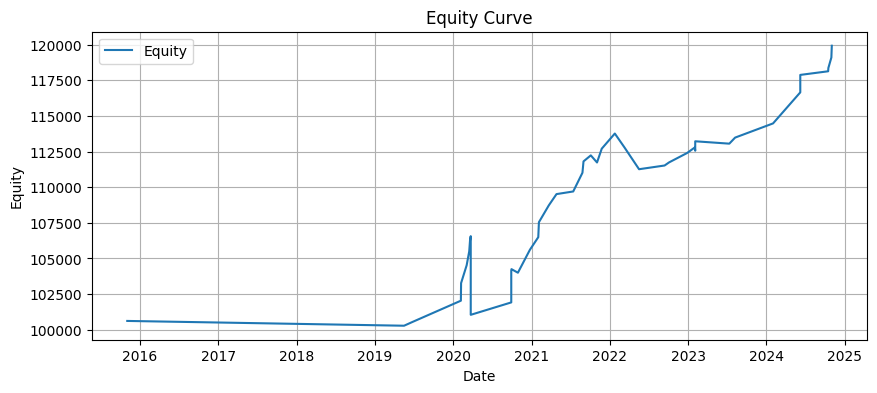

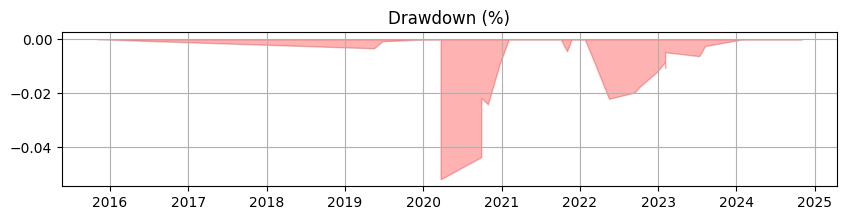

In [98]:
import matplotlib.pyplot as plt

# initialize
equity = INITIAL_CAPITAL
equity_curve = []
for _, row in closed_df.iterrows():
    equity += row['pnl']
    equity_curve.append((row['exit_date'], equity))

equity_df = pd.DataFrame(equity_curve, columns=['date', 'equity']).set_index('date')

# --- PERFORMANCE METRICS ---
equity_df['drawdown'] = equity_df['equity'] / equity_df['equity'].cummax() - 1
max_drawdown = equity_df['drawdown'].min()

winners = closed_df[closed_df['pnl'] > 0]
losers = closed_df[closed_df['pnl'] < 0]
win_rate = len(winners) / len(closed_df) * 100 if len(closed_df) > 0 else 0
avg_win = winners['pnl'].mean() if not winners.empty else 0
avg_loss = abs(losers['pnl'].mean()) if not losers.empty else 0
win_loss_ratio = (avg_win / avg_loss) if avg_loss > 0 else np.nan

# --- PRINT SUMMARY ---
print("=== PERFORMANCE SUMMARY ===")
print(f"Final Equity: {equity_df['equity'].iloc[-1]:.2f}")
print(f"Total Return: {(equity_df['equity'].iloc[-1] / INITIAL_CAPITAL - 1)*100:.2f}%")
print(f"Max Drawdown: {max_drawdown*100:.2f}%")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Average Win: {avg_win:.2f}")
print(f"Average Loss: {-avg_loss:.2f}")
print(f"Win/Loss Ratio: {win_loss_ratio:.2f}")
print(f"Total Trades: {len(closed_df)}")
print(f"Winners: {len(winners)} | Losers: {len(losers)}")

# --- PLOT EQUITY CURVE ---
plt.figure(figsize=(10, 4))
plt.plot(equity_df.index, equity_df['equity'], label='Equity')
plt.title("Equity Curve")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.grid(True)
plt.legend()
plt.show()

# --- OPTIONAL: PLOT DRAWDOWN ---
plt.figure(figsize=(10, 2))
plt.fill_between(equity_df.index, equity_df['drawdown'], 0, color='red', alpha=0.3)
plt.title("Drawdown (%)")
plt.grid(True)
plt.show()